
<table>
<tr>
<td> <img src ="http://www.argo-france.fr/wp-content/uploads/2019/10/Argo-logo_banner-color.png"
WIDTH=200 HEIGHT=200/> </td>
<td> <img src="https://www.imt-atlantique.fr/sites/default/files/Images/Ecole/charte-graphique/IMT_Atlantique_logo_RVB_Baseline_400x272.jpg"
WIDTH=200 HEIGHT=200/> </td>
</tr>
</table>

<CENTER>
</br>
<p><font size="5"> TAF MCE - 2019</span></p>
<p><font size="4">  UE Projet S5 </font></p>
<p></p>
<p><font size="5">  Santiago AGUDELO & Van-Khoa NGUYEN </font></p>
</p></br>
</p>
</CENTER>


# Preprocessing

In [8]:
# Import Libraries
!apt-get -qq install python-cartopy python3-cartopy
!pip install netCDF4
!apt-get install libgeos-3* libgeos-dev
!pip install https://github.com/matplotlib/basemap/archive/master.zip
from mpl_toolkits.basemap import Basemap
import cartopy
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import xarray as xr
from pickle import load
from pickle import dump
import numpy as np
from datetime import datetime
import os
import math
%matplotlib inline
%pylab inline
import sklearn
from scipy.stats.mstats import zscore
import warnings
# Deeplearning libraries import
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Input, concatenate, LSTM
from tensorflow.keras import Sequential, Model
from tensorflow.keras.models import load_model
from keras.layers.normalization import BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam
from keras.utils import np_utils
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from tensorflow.keras import backend as K
from sklearn.preprocessing import MinMaxScaler
warnings.filterwarnings("ignore") # disable warnings•••••••••••••
#pylab.rcParams['figure.figsize']=(15,20) # graph size
#from mpl_toolkits.basemap import Basemap

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Note, selecting 'libgeos-3.6.2' for glob 'libgeos-3*'
libgeos-3.6.2 is already the newest version (3.6.2-1build2).
libgeos-dev is already the newest version (3.6.2-1build2).
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.
  Using cached https://github.com/matplotlib/basemap/archive/master.zip
  Created wheel for basemap: filename=basemap-1.2.1-cp36-cp36m-linux_x86_64.whl size=121756020 sha256=5db7759c0fcdea2d333d8502dfd3dcb3cab06b85f04b641075c9d2ca31041eef
  Stored in directory: /tmp/pip-ephem-wheel-cache-s2kiis2d/wheels/98/4a/fc/ce719b75d97e646645c225f3332b1b217536100314922e9572
Successfully built basemap
Populating the interactive namespace from numpy and matplotlib


In [0]:
import matplotlib as mpl

# function to plot images  
def plot_im(lon,lat,im,size_points,var_name,types):
    
    # transform to arrays (just in case)
    lon=array(lon)
    lat=array(lat)
    im=array(im)
    
    if max(lon)-min(lon)<1000:
      # Mercator projection (for small zone)
      m=Basemap(projection='merc',llcrnrlat=nanmin(lat),urcrnrlat=nanmax(lat),\
                llcrnrlon=nanmin(lon),urcrnrlon=nanmax(lon),lat_0=(nanmax(lat)+nanmin(lat))*0.5,\
                lon_0=(nanmax(lon)+nanmin(lon))*0.5,resolution='l')
    else:
      # Orthogonal projection (for large zone)
      m=Basemap(projection='ortho',lat_0=0,lon_0=0,resolution='l')
    # you can use other projections (see https://matplotlib.org/basemap/users/mapsetup.html)
    
    # transform (lon,lat) to (x,y)
    x,y=m(lon,lat)


    # plot
    if types == "difft":
      vmin = -5
      vmax = 5
      norm = mpl.colors.DivergingNorm(vmin=vmin, vcenter=0, vmax=vmax)
      cmap = cm.get_cmap('bwr',20)
    if types == "temp":
      vmin = 0
      vmax = 30
      norm = None
      cmap = cm.get_cmap('jet',60)
    if types == "sal":
      vmin = np.quantile(im, 0.05, axis=0)
      vmax = np.quantile(im, 0.95, axis=0)
      norm = None
      cmap = cm.get_cmap('rainbow',20)
    if types == "diffs":
      cmap = cm.get_cmap('terrain')
      vmin = np.min(im) 
      vmax = np.max(im)
      norm = mpl.colors.DivergingNorm(vmin=vmin, vcenter=0, vmax=vmax)
    

    # define your scale, with white at zero
    im=ma.masked_where(isnan(im),im)
    res=m.scatter(x,y,size_points,im,'o',alpha=1,cmap = cmap,lw=0, vmin=vmin, vmax=vmax, norm=norm)
    m.drawcoastlines()
    m.fillcontinents()
    parallels = linspace(20,50,int((50-20)/5)+1)
    meridians = linspace(130,190,int((190-130)/5)+1)
    m.drawparallels(parallels,labels=[1,0,0,1],fontsize=10)
    m.drawmeridians(meridians,labels=[1,0,0,1],fontsize=10)

    cb=m.colorbar(res,location="right")
    cb.set_label(var_name,fontsize=15)
    #plt.clim(-np.max(im), np.max(im));

# function to plot time series
def plot_ts(time,ts,line_type,var_name):

    # plot
    plot_date(time,ts,line_type)
    xlabel('Time',fontsize=15)
    ylabel(var_name,fontsize=15)

In [10]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/My Drive/S5-project'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
data = pd.read_pickle(path+"/datakuroshio2.pkl")

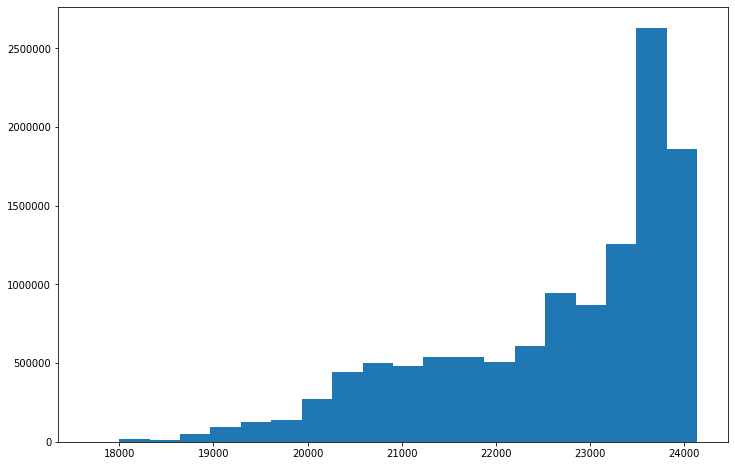

In [0]:
plt.figure(figsize=(12,8))
plt.hist((data['juld']),bins=20)
plt.show()

In [0]:
data

,temp,pres,psal,lat,lon,juld,sla,profile_ids
0,13.427,1.800000,34.006199,39.521000,148.578995,17673.314453,-0.058381,4
1,13.440,3.300000,34.006302,39.521000,148.578995,17673.314453,-0.058381,4
2,13.378,8.800000,33.991001,39.521000,148.578995,17673.314453,-0.058381,4
3,13.487,19.000000,34.027100,39.521000,148.578995,17673.314453,-0.058381,4
4,13.782,28.600000,34.124298,39.521000,148.578995,17673.314453,-0.058381,4
...,...,...,...,...,...,...,...,...
11883092,2.865,1049.900024,34.383999,44.124001,176.412994,23972.816406,0.085956,11105
11883093,2.808,1099.400024,34.396999,44.124001,176.412994,23972.816406,0.085956,11105
11883094,2.658,1200.300049,34.431999,44.124001,176.412994,23972.816406,0.085956,11105
11883095,2.471,1300.300049,34.466000,44.124001,176.412994,23972.816406,0.085956,11105


### Plot


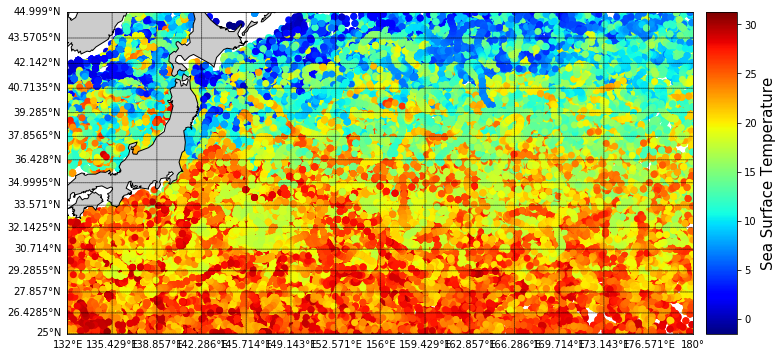

In [0]:
plt.figure(figsize=(12,8))
plot_im(df2.lon, df2.lat , df2.temp ,50,'Sea Surface Temperature')

# Models


### Model Simple

In [0]:
def dnn_model(n_lay = 2, activation_fun= 'relu'):
    
    model = Sequential()
    inputm = Input(shape=(8,))
    x = Dense(128, activation=activation_fun,kernel_initializer="glorot_uniform")(inputm)
    for lay in range(n_lay):
      x = Dense(128,activation=activation_fun,kernel_initializer="glorot_uniform")(x)
    rt = Dense(32,activation=activation_fun,kernel_initializer="glorot_uniform")(x)
    rs = Dense(32,activation=activation_fun,kernel_initializer="glorot_uniform")(x)
    rt = Dense(1,name="Temperature_output")(rt)
    rs = Dense(1,name="Salinity_output")(rs)
  
    model = Model(inputs=inputm, outputs=[rt, rs],name="Model simple")
    model.compile(loss=['mse','mse'], optimizer="adam", metrics=['mse','mae'])
    return model

model = dnn_model(n_lay = 6, activation_fun= 'relu')

model.summary()

Model: "Model simple"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense_45 (Dense)                (None, 128)          1152        input_6[0][0]                    
__________________________________________________________________________________________________
dense_46 (Dense)                (None, 128)          16512       dense_45[0][0]                   
__________________________________________________________________________________________________
dense_47 (Dense)                (None, 128)          16512       dense_46[0][0]                   
_______________________________________________________________________________________

### Model Parallel

In [0]:
def dnn_model_p(n_lay = 2 , activation_fun = 'relu'):

    model = Sequential()
    inputm = Input(shape=(8,))
    rt = Dense(128, activation=activation_fun)(inputm)
    for lay in range(n_lay):
      rt = Dense(128, activation=activation_fun)(rt)
    rt = Dense(32,activation=activation_fun)(rt)
    rt = Dense(1,name="Temperature_output")(rt)

    rs = Dense(128, activation=activation_fun)(inputm)
    for lay in range(n_lay):
      rs = Dense(128, activation=activation_fun)(rs)
    rs = Dense(32,activation=activation_fun)(rs)
    rs = Dense(1,name="Salinity_output")(rs)

    model = Model(inputs=inputm, outputs=[rt, rs],name="Model Parallel")
    
    model.compile(loss=['mse','mse'], optimizer='adam', metrics=['mse','mae'])
    return model

model = dnn_model_p(n_lay = 2, activation_fun = 'relu')

model.summary()

Model: "Model Parallel"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense_54 (Dense)                (None, 128)          1152        input_7[0][0]                    
__________________________________________________________________________________________________
dense_58 (Dense)                (None, 128)          1152        input_7[0][0]                    
__________________________________________________________________________________________________
dense_55 (Dense)                (None, 128)          16512       dense_54[0][0]                   
_____________________________________________________________________________________

### Model Cascade


In [0]:
def dnn_model_c(n_lay = 2, activation_fun= 'relu'):
    
    # descomposition
    nt = []
    ns = []
    for n in range(0,n_lay+1):
      if n%2 == 0:
        nt.append(n)
      else:
        ns.append(n)
    model = Sequential()
    inputm = Input(shape=(8,))
    rt = Dense(128, activation=activation_fun,kernel_initializer="glorot_uniform")(inputm)
    for lay in range(len(nt)):
      rt = Dense(128,activation=activation_fun,kernel_initializer="glorot_uniform")(rt)
    rt = Dense(32,activation=activation_fun,kernel_initializer="glorot_uniform")(rt)
    rt = Dense(1,name="Temperature_output")(rt)

    inputs = concatenate([inputm,rt])
    rs = Dense(128, activation=activation_fun,kernel_initializer="glorot_uniform")(inputs)
    for lay in range(len(ns)):
      rs = Dense(128,activation=activation_fun,kernel_initializer="glorot_uniform")(rs)
    rs = Dense(32,activation=activation_fun,kernel_initializer="glorot_uniform")(rs)
    rs = Dense(1,name="Salinity_output")(rs)
  
    model = Model(inputs=inputm, outputs=[rt, rs],name="Model Cascade")
    model.compile(loss=['mse','mse'], optimizer="adam", metrics=['mse','mae'])
    return model

model = dnn_model_c(n_lay = 7, activation_fun= 'relu')

model.summary()

Model: "Model Cascade"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense_70 (Dense)                (None, 128)          1152        input_9[0][0]                    
__________________________________________________________________________________________________
dense_71 (Dense)                (None, 128)          16512       dense_70[0][0]                   
__________________________________________________________________________________________________
dense_72 (Dense)                (None, 128)          16512       dense_71[0][0]                   
______________________________________________________________________________________

### Model Junction

In [0]:
def dnn_model_j(n_lay = 2, activation_fun= 'relu'):
    
    model = Sequential()
    inputm = Input(shape=(8,))

    x = Dense(128, activation=activation_fun,kernel_initializer="glorot_uniform")(inputm)
    xt = Dense(128, activation=activation_fun,kernel_initializer="glorot_uniform")(x)
    xs = Dense(128, activation=activation_fun,kernel_initializer="glorot_uniform")(x)
    if n_lay != 0:
      for lay in range(n_lay):
        x = concatenate([xt,xs])
        x = Dense(64, activation=activation_fun,kernel_initializer="glorot_uniform")(x)
        xt = Dense(128, activation=activation_fun,kernel_initializer="glorot_uniform")(x)
        xs = Dense(128, activation=activation_fun,kernel_initializer="glorot_uniform")(x)
    rt = Dense(32,activation=activation_fun,kernel_initializer="glorot_uniform")(xt)
    rs = Dense(32,activation=activation_fun,kernel_initializer="glorot_uniform")(xs)
    rt = Dense(1,name="Temperature_output")(rt)
    rs = Dense(1,name="Salinity_output")(rs)
  
    model = Model(inputs=inputm, outputs=[rt, rs],name="Model Junction")
    model.compile(loss=['mse','mse'], optimizer="adam", metrics=['mse','mae'])
    return model

model = dnn_model_j(n_lay = 1, activation_fun= 'relu')

model.summary()

Model: "Model Junction"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense_85 (Dense)                (None, 128)          1152        input_11[0][0]                   
__________________________________________________________________________________________________
dense_86 (Dense)                (None, 128)          16512       dense_85[0][0]                   
__________________________________________________________________________________________________
dense_87 (Dense)                (None, 128)          16512       dense_85[0][0]                   
_____________________________________________________________________________________

### dnn test models

In [0]:
def dnn_model1():
    
    model = Sequential()
    inputm = Input(shape=(8,))
    x = Dense(128, activation='relu')(inputm)
    x = Dense(128, activation='relu')(x)
    x = Dense(256, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    rt = Dense(32,activation='relu')(x)
    rs = Dense(32,activation='relu')(x)
    rt = Dense(1,name="Temperature_output")(rt)
    rs = Dense(1,name="Salinity_output")(rs)
  
    model = Model(inputs=inputm, outputs=[rt, rs],name="Model dnn1")
    
    model.compile(loss=['mse','mse'], optimizer='adam', metrics=['mse','mae'])
    return model

model = dnn_model1()

model.summary()

Model: "Model dnn1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense_72 (Dense)                (None, 128)          1152        input_14[0][0]                   
__________________________________________________________________________________________________
dense_73 (Dense)                (None, 128)          16512       dense_72[0][0]                   
__________________________________________________________________________________________________
dense_74 (Dense)                (None, 256)          33024       dense_73[0][0]                   
_________________________________________________________________________________________

In [0]:
def dnn_model2():
    
    model = Sequential()
    inputm = Input(shape=(8,))
    x = Dense(128, activation='relu')(inputm)
    x = Dense(128, activation='relu')(x)
    x = Dense(256, activation='relu')(x)
    x = Dense(256, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    rt = Dense(32,activation='relu')(x)
    rs = Dense(32,activation='relu')(x)
    rt = Dense(1,name="Temperature_ouput")(rt)
    rs = Dense(1,name="Salinity_ouput")(rs)
  
    model = Model(inputs=inputm, outputs=[rt, rs],name="Model dnn")
    opt = Adam(learning_rate=0.0005)
    model.compile(loss=['mse','mse'], optimizer='adam', metrics=['mse','mae'])
    return model

model = dnn_model2()

model.summary()

Model: "Model dnn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense_32 (Dense)                (None, 128)          1152        input_7[0][0]                    
__________________________________________________________________________________________________
dense_33 (Dense)                (None, 128)          16512       dense_32[0][0]                   
__________________________________________________________________________________________________
dense_34 (Dense)                (None, 256)          33024       dense_33[0][0]                   
__________________________________________________________________________________________

In [0]:
def dnn_model4():
    
    model = Sequential()
    inputm = Input(shape=(8,))
    x = Dense(128, activation='relu')(inputm)
    x = Dense(128, activation='relu')(x)
    x = Dense(256, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    rt = Dense(32,activation='relu')(x)
    rs = Dense(32,activation='relu')(x)
    rt = Dense(1,name="Temperature_ouput")(rt)
    rs = Dense(1,name="Salinity_ouput")(rs)
  
  
    model = Model(inputs=inputm, outputs=[rt, rs],name="Model dnn")
    opt = Adam(learning_rate=0.00035)
    model.compile(loss=['mse','mse'], optimizer='adam', metrics=['mse','mae'])
    return model

model = dnn_model4()

model.summary()

Model: "Model dnn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense_51 (Dense)                (None, 128)          1152        input_10[0][0]                   
__________________________________________________________________________________________________
dense_52 (Dense)                (None, 128)          16512       dense_51[0][0]                   
__________________________________________________________________________________________________
dense_53 (Dense)                (None, 256)          33024       dense_52[0][0]                   
__________________________________________________________________________________________

In [0]:
def dnn_model5():
    
    model = Sequential()
    inputm = Input(shape=(8,))
    x = Dense(128, activation='relu')(inputm)
    x = Dense(128, activation='relu')(x)
    rt = Dense(32,activation='relu')(x)
    rs = Dense(32,activation='relu')(x)
    rt = Dense(1,name="Temperature_ouput")(rt)
    rs = Dense(1,name="Salinity_ouput")(rs)
  
  
    model = Model(inputs=inputm, outputs=[rt, rs],name="Model dnn 5")
    model.compile(loss=['mse','mse'], optimizer='adam', metrics=['mse','mae'])
    return model

model = dnn_model5()

model.summary()

Model: "Model dnn 5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense_84 (Dense)                (None, 128)          1152        input_17[0][0]                   
__________________________________________________________________________________________________
dense_85 (Dense)                (None, 128)          16512       dense_84[0][0]                   
__________________________________________________________________________________________________
dense_86 (Dense)                (None, 32)           4128        dense_85[0][0]                   
________________________________________________________________________________________

### ann test models

In [0]:
def ann_model():
    
    model = Sequential()
    inputm = Input(shape=(1,8))
    x = LSTM(100)(inputm)
    x = Dense(128, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(256, activation='relu')(x)
    rt = Dense(32,activation='relu')(x)
    rs = Dense(32,activation='relu')(x)
    rt = Dense(1)(rt)
    rs = Dense(1)(rs)
  
    model = Model(inputs=inputm, outputs=[rt, rs])
    
    model.compile(loss=['mse','mse'], optimizer='adam', metrics=['mse','mae'])
    return model

model = ann_model()

model.summary()

Model: "model_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_25 (InputLayer)           [(None, 1, 8)]       0                                            
__________________________________________________________________________________________________
lstm_11 (LSTM)                  (None, 100)          43600       input_25[0][0]                   
__________________________________________________________________________________________________
dense_149 (Dense)               (None, 128)          12928       lstm_11[0][0]                    
__________________________________________________________________________________________________
dense_150 (Dense)               (None, 128)          16512       dense_149[0][0]                  
___________________________________________________________________________________________

In [0]:
def ann_model2():
    
    model = Sequential()
    inputm = Input(shape=(8,))
    rt = Dense(128, activation='relu')(inputm)
    rt = Dense(128, activation='relu')(rt)
    rt = Dense(128, activation='relu')(rt)
    rt = Dense(32,activation='relu')(rt)
    rt = Dense(32,activation='relu')(rt)
    rt = Dense(1)(rt)

    rs = Dense(128, activation='relu')(inputm)
    rs = Dense(128, activation='relu')(rs)
    rs = Dense(128, activation='relu')(rs)
    rs = Dense(32,activation='relu')(rs)
    rs = Dense(32,activation='relu')(rs)
    rs = Dense(1)(rs)
  
    model = Model(inputs=inputm, outputs=[rt, rs])
    
    model.compile(loss=['mse','mse'], optimizer='adam', metrics=['mse','mae'])
    return model

model = ann_model2()

model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense_48 (Dense)                (None, 128)          1152        input_6[0][0]                    
__________________________________________________________________________________________________
dense_54 (Dense)                (None, 128)          1152        input_6[0][0]                    
__________________________________________________________________________________________________
dense_49 (Dense)                (None, 128)          16512       dense_48[0][0]                   
____________________________________________________________________________________________

In [0]:
def ann_model3():
    
    model = Sequential()
    inputm = Input(shape=(8,))
    rt = Dense(128, activation='relu')(inputm)
    rt = Dense(128, activation='relu')(rt)
    rt = Dense(256, activation='relu')(rt)
    rt = Dense(32,activation='relu')(rt)
    rt = Dense(1)(rt)

    inputs =  concatenate([inputm, rt])
    rs = Dense(128, activation='relu')(inputs)
    rs = Dense(128, activation='relu')(rs)
    rs = Dense(128, activation='relu')(rs)
    rs = Dense(128, activation='relu')(rs)
    rs = Dense(128, activation='relu')(rs)
    rs = Dense(32,activation='relu')(rs)
    rs = Dense(16,activation='relu')(rs)
    rs = Dense(1)(rs)
  
    model = Model(inputs=inputm, outputs=[rt, rs])
    
    model.compile(loss=['mse','mse'], optimizer='adam', metrics=['mse','mae'])
    return model

model = ann_model3()

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_28 (InputLayer)           [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense_141 (Dense)               (None, 128)          1152        input_28[0][0]                   
__________________________________________________________________________________________________
dense_142 (Dense)               (None, 128)          16512       dense_141[0][0]                  
__________________________________________________________________________________________________
dense_143 (Dense)               (None, 256)          33024       dense_142[0][0]                  
____________________________________________________________________________________________

Model: "Model dnn parallel"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 128)          1152        input_2[0][0]                    
__________________________________________________________________________________________________
dense_12 (Dense)                (None, 128)          1152        input_2[0][0]                    
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 128)          16512       dense_8[0][0]                    
_________________________________________________________________________________

Model: "Model dnn simple"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 128)          1152        input_2[0][0]                    
__________________________________________________________________________________________________
dense_10 (Dense)                (None, 128)          16512       dense_9[0][0]                    
__________________________________________________________________________________________________
dense_11 (Dense)                (None, 128)          16512       dense_10[0][0]                   
___________________________________________________________________________________

# Training process

In [0]:
X = np.zeros([len(data),8])
y1 = np.zeros([len(data),1])
y2 = np.zeros([len(data),2])
X[:,0] = np.cos(data['lon']*(np.pi/180))
X[:,1] = np.sin(data['lon']*(np.pi/180))
X[:,2] = data['lat']
X[:,3] = data['juld']
w = 1/365.25
X[:,4] = np.cos(np.pi*2*w*data['juld'])
X[:,5] = np.sin(np.pi*2*w*data['juld'])
X[:,6] = data['pres']
X[:,7] = data['sla']
y1 = np.array(data['temp'])
y2 = np.array(data['psal'])

In [0]:
y1

array([13.427, 13.44 , 13.378, ...,  2.39 ,  2.3  ,  2.221], dtype=float32)

In [0]:
y1=y1.reshape(-1,1)
y2=y2.reshape(-1,1)
scaler_x = MinMaxScaler()
scaler_y1 = MinMaxScaler()
scaler_y2 = MinMaxScaler()
print(scaler_x.fit(X))
xscale=scaler_x.transform(X)
print(scaler_y1.fit(y1))
print(scaler_y2.fit(y2))
yscale1=scaler_y1.transform(y1)
yscale2=scaler_y2.transform(y2)

MinMaxScaler(copy=True, feature_range=(0, 1))
MinMaxScaler(copy=True, feature_range=(0, 1))
MinMaxScaler(copy=True, feature_range=(0, 1))


In [0]:
# save the scalers
dump(scaler_x, open(path+'/scalerx.pkl', 'wb'))
dump(scaler_y1, open(path+'/scalert.pkl', 'wb'))
dump(scaler_y2, open(path+'/scalers.pkl', 'wb'))

### K-fold validation

In [0]:
from sklearn.model_selection import KFold
import pandas as pd

n_split=3
i = 1
for train_index,test_index in KFold(n_split).split(xscale):

  X_train,X_test = xscale[train_index],xscale[test_index]
  y_train1,y_test1 = yscale1[train_index],yscale1[test_index]
  y_train2,y_test2 = yscale2[train_index],yscale2[test_index]
  
  print(i)
  model = dnn_model_j(n_lay = 1, activation_fun= 'relu')
  checkpoint_path =path+ "/data/training_dnnJ_kfold"+str(i)+"/cp-{epoch:04d}.ckpt"
  checkpoint_dir = os.path.dirname(checkpoint_path)
  cp_callback   = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min', min_delta=0.0001),
                tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, verbose=1, save_weights_only=True,period=2)]
  # Save the weights using the `checkpoint_path` format
  model.save_weights(checkpoint_path.format(epoch=0))
  history = model.fit(X_train, [y_train1,y_train2], epochs=30, batch_size=int(X.shape[0]*(16/1000)),callbacks=cp_callback,  verbose=1, validation_data=(X_test, [y_test1,y_test2]))
  model.save(path+'/data/model_dnnJ_k'+str(i)+'.h5')
  pd.DataFrame.from_dict(history.history).to_csv(path+'/data/history_model_dnnJ_k'+str(i)+'.csv',index=False)
  i+= 1
  
  #print('Model evaluation ',model.evaluate(x_test,y_test))

1
Train on 11405550 samples, validate on 5702776 samples
Epoch 1/30
11405550/11405550 [==============================] - 156s 14us/sample - loss: 0.1084 - Temperature_output_loss: 0.0415 - Salinity_output_loss: 0.0662 - Temperature_output_mean_squared_error: 0.0417 - Temperature_output_mean_absolute_error: 0.1639 - Salinity_output_mean_squared_error: 0.0667 - Salinity_output_mean_absolute_error: 0.1678 - val_loss: 0.0331 - val_Temperature_output_loss: 0.0257 - val_Salinity_output_loss: 0.0074 - val_Temperature_output_mean_squared_error: 0.0257 - val_Temperature_output_mean_absolute_error: 0.1298 - val_Salinity_output_mean_squared_error: 0.0074 - val_Salinity_output_mean_absolute_error: 0.0692
Epoch 2/30
11223053/11405550 [============================>.] - ETA: 2s - loss: 0.0103 - Temperature_output_loss: 0.0080 - Salinity_output_loss: 0.0023 - Temperature_output_mean_squared_error: 0.0080 - Temperature_output_mean_absolute_error: 0.0644 - Salinity_output_mean_squared_error: 0.0023 - Sa

### Complexity adjustment

In [0]:
X_train = xscale[0:int(ceil(len(data)*0.7)),:]
y_train1 = yscale1[0:int(ceil(len(data)*0.7))]
y_train2 = yscale2[0:int(ceil(len(data)*0.7))]

X_test = xscale[int(ceil(len(data)*0.7)):,:]
y_test1 = yscale1[int(ceil(len(data)*0.7)):]
y_test2 = yscale2[int(ceil(len(data)*0.7)):]

In [0]:
for n_lay in [0,1,2,4,8,10]:
  print("============ : ",n_lay)
  model = dnn_model_p(dimint_layers = n_lay, activation_fun = 'relu')
  model.summary(line_length=1)
  # Include the epoch in the file name (uses `str.format`)
  checkpoint_path =path+ "/complexity/training_dnn_p_nlay"+str(n_lay)+"/cp-{epoch:04d}.ckpt"
  checkpoint_dir = os.path.dirname(checkpoint_path)
  # Create a callback that saves the model's weights every 2 epochs
  cp_callback   = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min', min_delta=0.0001),
                  tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, verbose=1, save_weights_only=True,period=2)]
  # Save the weights using the `checkpoint_path` format
  model.save_weights(checkpoint_path.format(epoch=0))

  history = model.fit(X_train, [y_train1,y_train2], epochs=30, batch_size=int(X.shape[0]*(16/1000)), callbacks=cp_callback,  verbose=1, validation_data=(X_test,[y_test1,y_test2]))

  # Save final model
  model.save(path+'/complexity/modeldnnp_nlay'+str(n_lay)+'.h5')

  # Save history
  pd.DataFrame.from_dict(history.history).to_csv(path+'/complexity/history_modeldnnp_nlay'+str(n_lay)+'.csv',index=False)

============ :  0
Model: "Model dnn parallel"
_
 
=
 
_
 
_
 
_
 
_
 
_
 
_
 
=
Total params: 10,626
Trainable params: 10,626
Non-trainable params: 0
_
Train on 11975829 samples, validate on 5132497 samples
Epoch 1/30
11975829/11975829 [==============================] - 49s 4us/sample - loss: 0.2077 - Temperature_output_loss: 0.0364 - Salinity_output_loss: 0.1703 - Temperature_output_mean_squared_error: 0.0365 - Temperature_output_mean_absolute_error: 0.1528 - Salinity_output_mean_squared_error: 0.1712 - Salinity_output_mean_absolute_error: 0.3079 - val_loss: 0.0274 - val_Temperature_output_loss: 0.0159 - val_Salinity_output_loss: 0.0115 - val_Temperature_output_mean_squared_error: 0.0159 - val_Temperature_output_mean_absolute_error: 0.1020 - val_Salinity_output_mean_squared_error: 0.0115 - val_Salinity_output_mean_absolute_error: 0.0832
Epoch 2/30
11770519/11975829 [============================>.] - ETA: 0s - loss: 0.0153 - Temperature_output_loss: 0.0107 - Salinity_output_loss: 0.004

dict_keys(['loss', 'Temperature_output_loss', 'Salinity_output_loss', 'Temperature_output_mean_squared_error', 'Temperature_output_mean_absolute_error', 'Salinity_output_mean_squared_error', 'Salinity_output_mean_absolute_error', 'val_loss', 'val_Temperature_output_loss', 'val_Salinity_output_loss', 'val_Temperature_output_mean_squared_error', 'val_Temperature_output_mean_absolute_error', 'val_Salinity_output_mean_squared_error', 'val_Salinity_output_mean_absolute_error'])


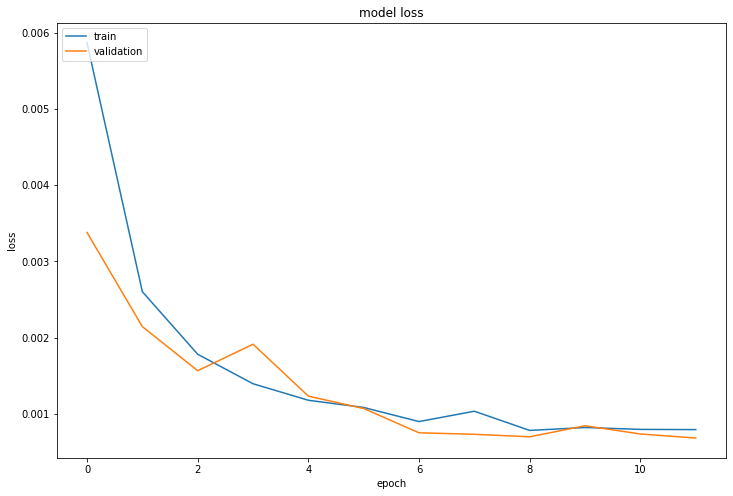

In [0]:
print(history.history.keys())
# "Loss"
plt.figure(figsize=(12,8))
plt.plot(history.history['loss'][:])
plt.plot(history.history['val_loss'][:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [0]:
model.save(path+'/modeldnn6.h5')


In [0]:
import pandas as pd 
pd.DataFrame.from_dict(history.history).to_csv(path+"/history_modeldnn6.csv",index=False)

## Evaluation models

### Cross-validation

In [0]:
X_test = X[int(ceil(len(data)*0.7)):len(data),:]
y_test1 = y1[int(ceil(len(data)*0.7)):len(data)]
y_test2 = y2[int(ceil(len(data)*0.7)):len(data)]
X_test.shape

(5132497, 8)

In [0]:
# Evaluation of Kfolds
from sklearn.model_selection import KFold

Loss_dnn = {}
Loss_dnn['MAE_T'] = []
Loss_dnn['MSE_T'] = []
Loss_dnn['MAE_S'] = []
Loss_dnn['MSE_S'] = []
i = 1
for r,d,f in os.walk(path):
  if 'data' in r:
    for file in f:
      if 'dnnJ' in file and '.h5' in file:
        print(file)
        n_split=3
        k = 1
        for train_index,test_index in KFold(n_split).split(X):
          if i == k:         
            X_train,X_test = X[train_index],X[test_index]
            y_train1,y_test1 = y1[train_index],y1[test_index]
            y_train2,y_test2 = y2[train_index],y2[test_index]
          k += 1

        model = load_model(path+'/data/'+file)
        Xnew= scaler_x.transform(X_test)
        #Xnew = Xnew.reshape((Xnew.shape[0], 1, Xnew.shape[1]))
        [ynew1,ynew2]= model.predict(Xnew)

        #invert normalize
        ynew1 = scaler_y1.inverse_transform(ynew1)
        ynew2 = scaler_y2.inverse_transform(ynew2)

        from sklearn.metrics import mean_absolute_error
        from sklearn.metrics import mean_squared_error
        mae_t = mean_absolute_error(y_test1, ynew1)
        mse_t = mean_squared_error(y_test1, ynew1)
        mae_s = mean_absolute_error(y_test2, ynew2)
        mse_s = mean_squared_error(y_test2, ynew2)
        print("mae_t",mae_t)
        print("mse_t",mse_t)
        print("mae_s",mae_s)
        print("mse_s",mse_s)
        Loss_dnn['MAE_T'].append(mae_t)
        Loss_dnn['MSE_T'].append(mse_t)
        Loss_dnn['MAE_S'].append(mae_s)
        Loss_dnn['MSE_S'].append(mse_s)
        i += 1

model_dnnJ_k1.h5
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
mae_t 0.8464889
mse_t 1.7702351
mae_s 0.24655966
mse_s 0.10715425
model_dnnJ_k2.h5
mae_t 0.5396656
mse_t 0.78602076
mae_s 0.15735409
mse_s 0.04239807
model_dnnJ_k3.h5
mae_t 0.57303876
mse_t 0.8632231
mae_s 0.20096941
mse_s 0.07733956


In [0]:
pd.DataFrame.from_dict(Loss_dnn).to_csv(path+"/data/errors_dnnJ.csv",index=False)

### BIC analysis

In [0]:
Loss_dnn = pd.read_csv(path+"/lstm/error_rnnL.csv")
Loss_dnn

n_un = [1,5,10,20,30,50,70,100]

In [0]:
# calculate aic for regression
def calculate_aic(n, mse, num_params):
	aic = n * log(mse) + 2 * num_params
	return aic


# calculate bic for regression
def calculate_bic(n, mse, num_params):
	bic = n * log(mse) + num_params * log(n)
	return bic

n_training = y1[:int(ceil(len(data)*0.7))].shape[0]
aict = []
aics = []
for i in range(len(Loss_dnn['MSE_T'])):
  mset = Loss_dnn['MSE_T'][i]
  mses = Loss_dnn['MSE_S'][i]
  num_params = Loss_dnn['num_params'][i]
  aict.append(calculate_bic(n_training, mset, num_params))
  aics.append(calculate_bic(n_training, mses, num_params))
  

Text(0.5, 0, 'number of LSTM units')

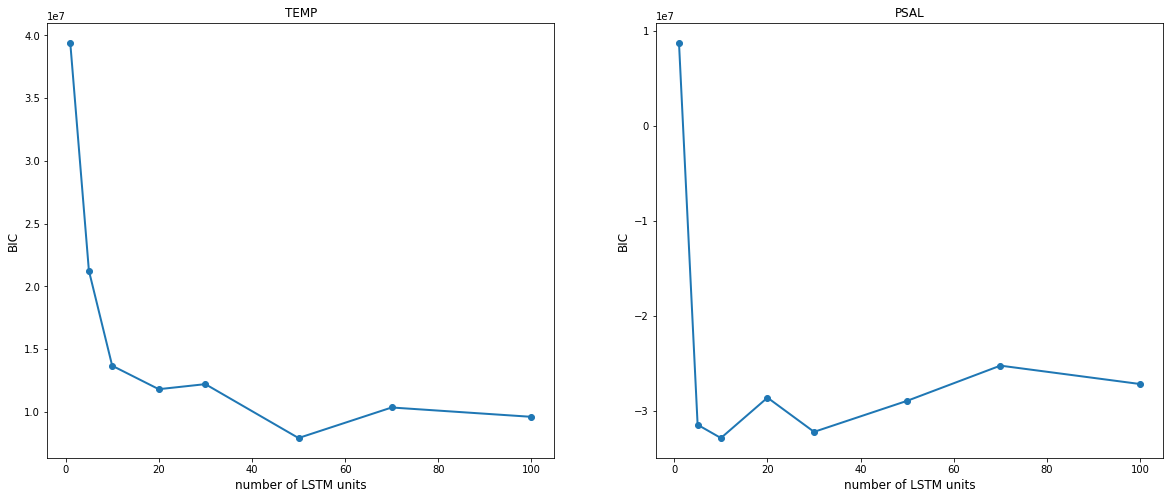

In [0]:
plt.figure(figsize=(20,8))

plt.subplot(1,2,1)
plt.plot(n_un,aict,'-o',lw=2)
plt.title('TEMP')
plt.ylabel("BIC",fontsize=12)
plt.xlabel("number of LSTM units",fontsize=12)
plt.subplot(1,2,2)
plt.title('PSAL')
plt.plot(n_un,aics,'-o',lw=2)
plt.ylabel("BIC",fontsize=12)
plt.xlabel("number of LSTM units",fontsize=12)
#plt.savefig(path+'/BIC_parallel.png')

### MSE analysis

In [0]:
Xnew= scaler_x.transform(X_test)
#Xnew = Xnew.reshape((Xnew.shape[0], 1, Xnew.shape[1]))
[ynew1,ynew2]= model.predict(Xnew)

#invert normalize
ynew1 = scaler_y1.inverse_transform(ynew1)
ynew2 = scaler_y2.inverse_transform(ynew2)

In [0]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
mae = mean_absolute_error(y_test1, ynew1)
mse = mean_squared_error(y_test1, ynew1)

print("MAE=%s, MSE=%s" % (mae, mse))

MAE=0.84665084, MSE=1.5924623


# Validation with real data 




### Superficial validation

In [0]:
date = "2020-03-15"


In [245]:
# Load model

typem = 'rnnSL'
model1 = load_model(path+'/data/model_'+typem+'_k1.h5')
model2 = load_model(path+'/data/model_'+typem+'_k2.h5')
model3 = load_model(path+'/data/model_'+typem+'_k3.h5')

# load the scalers

scaler_x = load(open(path+'/scalerx.pkl', 'rb'),allow_pickle=True)
scaler_yt = load(open(path+'/scalert.pkl', 'rb'),allow_pickle=True)
scaler_ys = load(open(path+'/scalers.pkl', 'rb'),allow_pickle=True)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
# Load validation data
if date>"2008-12-31" and date < "2012-05-28":
  dt = xr.open_dataset(path+'/GLO-SST-L4-NRT-OBS-GMPE.nc')
  dh = xr.open_dataset(path+'/SSH-L4-2008-2012.nc')
  dh['latitude'] = dh['latitude']+0.25
  dh = dh.drop_sel(longitude=129.875)
elif date>"2013-01-01" and date<"2017-12-31":
  dt = xr.open_dataset(path+'/GLO-SST-L4-NRT-OBS-GMPE-V2.nc')
  dh = xr.open_dataset(path+'/SSH-L4-2013-2019.nc')
  dh['latitude'] = dh['latitude']+0.25
  dh = dh.drop_sel(longitude=129.875)
elif date>"2018-01-01" and date<"2020-03-20":
  dt = xr.open_dataset(path+'/GLO-SST-L4-NRT-OBS-GMPE-V3_1.nc')
  dh = xr.open_dataset(path+'/SSH-L4-2017-2020.nc')
  dh = dh.drop_sel(longitude=190.125)
else:
  print("========== Error ==========")

In [318]:
rt = np.array(dt['analysed_sst'].sel(time=date))[-1]-273.15
rsla = np.array(dh['sla'].sel(time=date))
print("shape rt: ",rt.shape)
print("shape sla: ",rsla.shape)

shape rt:  (121, 240)
shape sla:  (121, 240)


In [319]:
lat = np.array(dt['lat'])
lon = np.array(dt['lon'])
lat = lat.repeat(rt.shape[1])
lon = np.tile(lon,rt.shape[0])
t = dt['time'].sel(time=date).values.astype('datetime64[s]')[0]
t = (datetime.timestamp(t.astype(datetime))/(3600*24))+(20*365.25)
print("time in juld:", t)

time in juld: 25641.5


In [0]:
n = len(lon)
t = t*np.ones(n)
z = 0*np.ones(n)
X = np.zeros([n,8])
y1 = np.zeros([n,1])
y2 = np.zeros([n,2])
X[:,0] = np.cos(lon*(np.pi/180))
X[:,1] = np.sin(lon*(np.pi/180))
X[:,2] = lat
X[:,3] = t
w = 1/365.25
X[:,4] = np.cos(np.pi*2*w*t)
X[:,5] = np.sin(np.pi*2*w*t)
X[:,6] = z
X[:,7] = rsla.reshape(-1)

In [321]:
Xscaled= scaler_x.transform(X)
Xscaled = Xscaled.reshape((Xscaled.shape[0], 1, Xscaled.shape[1]))
print("Evaluation first model .....")
[yt1,ys1]= model1.predict(Xscaled)
yt1 = scaler_yt.inverse_transform(yt1)
ys1 = scaler_ys.inverse_transform(ys1)
print("Evaluation second model .....")
[yt2,ys2]= model2.predict(Xscaled)
yt2 = scaler_yt.inverse_transform(yt2)
ys2 = scaler_ys.inverse_transform(ys2)
print("Evaluation third model .....")
[yt3,ys3]= model3.predict(Xscaled)
yt3 = scaler_yt.inverse_transform(yt3)
ys3 = scaler_ys.inverse_transform(ys3)

Evaluation first model .....
Evaluation second model .....
Evaluation third model .....


In [0]:
yt = (yt1+yt2+yt3)/3
ys = (ys1+ys2+ys3)/3

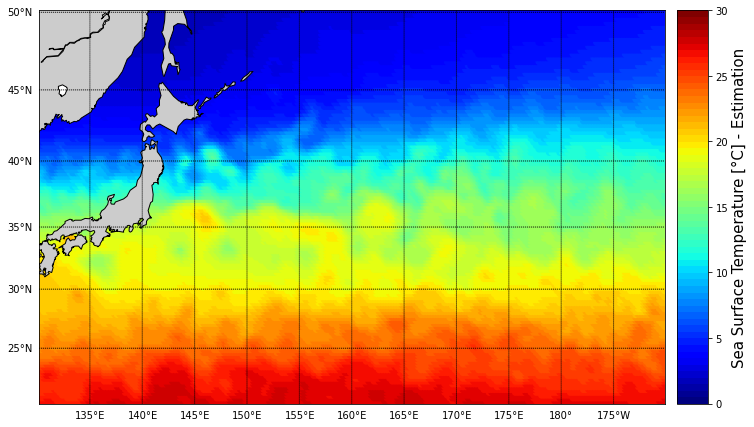

In [323]:
plt.figure(figsize=(12,8))
plot_im(lon, lat , yt.reshape(-1),50,'Sea Surface Temperature [°C] - Estimation',"temp")

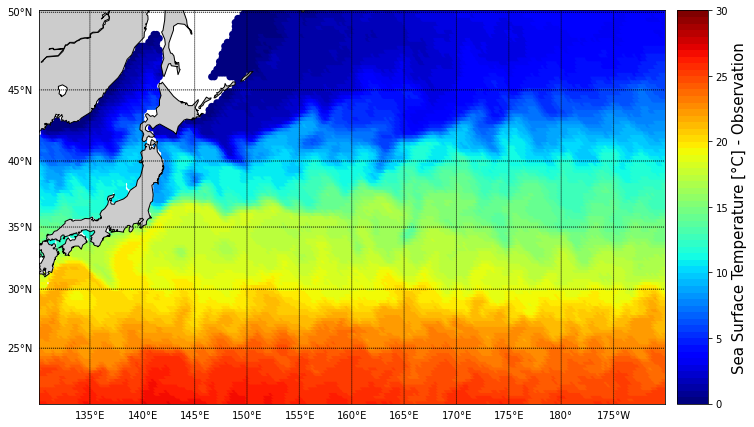

In [324]:
plt.figure(figsize=(12,8))
plot_im(lon, lat , rt.reshape(-1),50,'Sea Surface Temperature [°C] - Observation',"temp")

In [325]:
rt_ = rt
yt_ = yt

rt_[np.isnan(rt_)] = 0
yt_[np.isnan(yt_)] = 0

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
maet = mean_absolute_error(rt_.reshape(-1), yt_.reshape(-1))
mset = mean_squared_error(rt_.reshape(-1), yt_.reshape(-1))
print(mset)

3.8721435


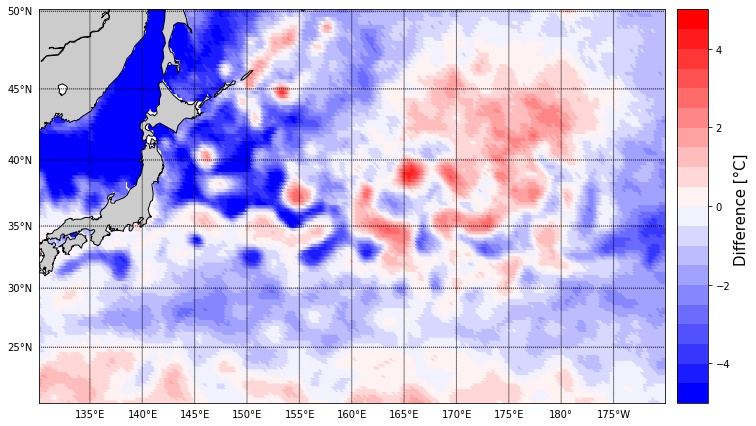

In [315]:
plt.figure(figsize=(12,8))
plot_im(lon, lat , yt.reshape(-1)-rt.reshape(-1),50,'Difference [°C] ','difft')

### SLA cyclon - anticyclon validation

In [0]:
# Load model

typem = 'rnnSL'
model1 = load_model(path+'/data/model_'+typem+'_k1.h5')
model2 = load_model(path+'/data/model_'+typem+'_k2.h5')
model3 = load_model(path+'/data/model_'+typem+'_k3.h5')

# load the scalers

scaler_x = load(open(path+'/scalerx.pkl', 'rb'),allow_pickle=True)
scaler_yt = load(open(path+'/scalert.pkl', 'rb'),allow_pickle=True)
scaler_ys = load(open(path+'/scalers.pkl', 'rb'),allow_pickle=True)

In [64]:
scaler_x

MinMaxScaler(copy=True, feature_range=(0, 1))

In [0]:
# Other variables
lon = 155
lat = 30
temps = "2017-10-05" 

In [488]:
from datetime import datetime

n_z = 1500
z0 = np.linspace(0,1500,n_z)

## SLA gaussian generation
n_test = 500
sigma = 14/1.96
sla0 = (0.5)*np.exp((-(np.linspace(0,80,n_test)-40)**2)/(2*sigma**2))
z = z0.repeat(n_test)
sla = np.tile(sla0,n_z)
print(z.shape)

n = len(sla)


t = datetime.strptime(temps, '%Y-%m-%d')
t = (datetime.timestamp(t)/(3600*24))+(20*365.25)
t

t = t*np.ones(n)
X = np.zeros([n,8])
lon = lon*np.ones(n)
lat = lat**np.ones(n)
X[:,0] = np.cos(lon*(np.pi/180))
X[:,1] = np.sin(lon*(np.pi/180))
X[:,2] = lat
X[:,3] = t
w = 1/365.25
X[:,4] = np.cos(np.pi*2*w*t)
X[:,5] = np.sin(np.pi*2*w*t)
X[:,6] = z
X[:,7] = sla

Xnew= scaler_x.transform(X)
#Xnew = Xnew.reshape((Xnew.shape[0], 1, Xnew.shape[1]))
#Xnew = Xnew.reshape((Xnew.shape[0], 1, Xnew.shape[1]))
[yt,ys]= model.predict(Xnew)

#invert normalize
yt = scaler_yt.inverse_transform(yt)
ys = scaler_ys.inverse_transform(ys)

(750000,)


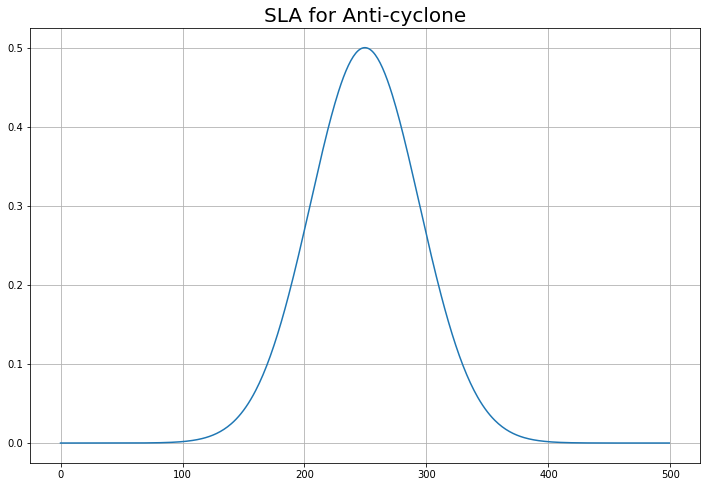

In [490]:
plt.figure(figsize=(12,8))
plt.title("SLA for Anti-cyclone",fontsize=20)
plt.plot(sla0)
plt.grid()

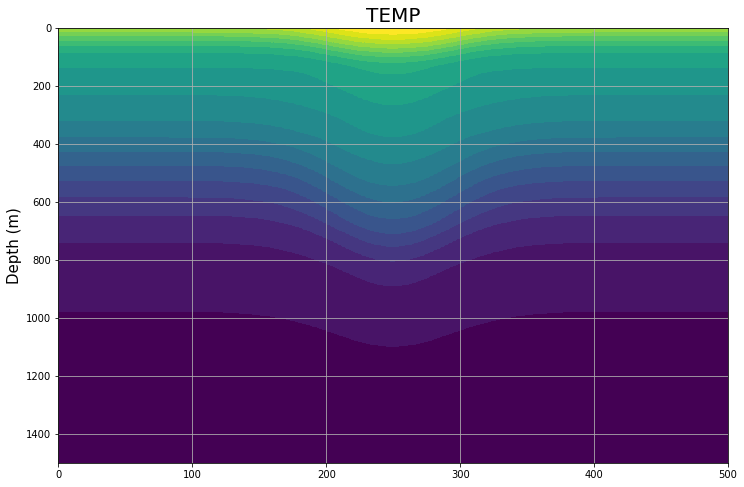

In [497]:
plt.figure(figsize=(12,8))
plt.pcolormesh(yt.reshape(n_z,n_test),cmap=cm.get_cmap('viridis',20))
plt.title("TEMP",fontsize=20)
plt.ylim(1500,0)
plt.ylabel("Depth (m)",fontsize=15)
plt.grid()
plt.show()

In [0]:
slt = yt.reshape(n_z,n_test)
dift = np.zeros((slt.shape[0],slt.shape[1]))
for nc in range(slt.shape[1]):
  dift[:,nc] = slt[:,nc] - slt[:,0]


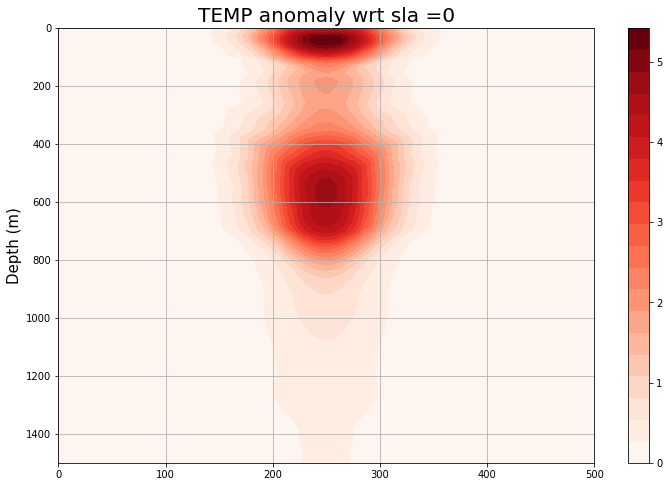

In [500]:
fig=plt.figure(figsize=(12,8))
ax = plt.pcolormesh(dift,cmap=cm.get_cmap('Reds',20))
cb=fig.colorbar(ax)
plt.title("TEMP anomaly wrt sla =0",fontsize=20)
plt.ylim(1500,0)
plt.ylabel("Depth (m)",fontsize=15)
plt.grid()
plt.show()

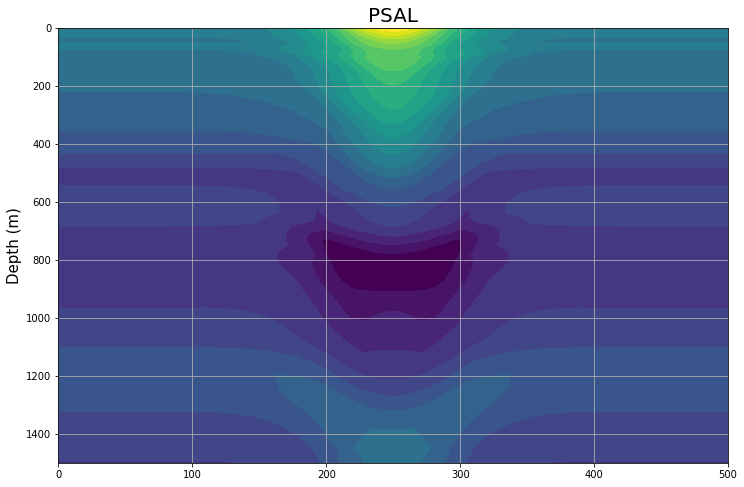

In [501]:
fig=plt.figure(figsize=(12,8))
plt.pcolormesh(ys.reshape(n_z,n_test),cmap=cm.get_cmap('viridis',20))
plt.title("PSAL",fontsize=20)
plt.ylim(1500,0)
plt.ylabel("Depth (m)",fontsize=15)
plt.grid()
plt.show()

In [0]:
sls = ys.reshape(n_z,n_test)
difs = np.zeros((sls.shape[0],sls.shape[1]))
for nc in range(sls.shape[1]):
  difs[:,nc] = sls[:,nc] - sls[:,0]

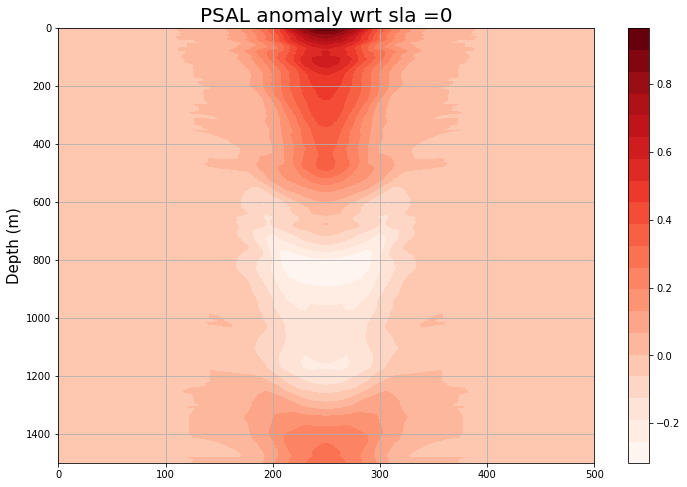

In [503]:
fig=plt.figure(figsize=(12,8))
ax = plt.pcolormesh(difs,cmap=cm.get_cmap('Reds',20))
cb=fig.colorbar(ax)
plt.title("PSAL anomaly wrt sla =0",fontsize=20)
plt.ylim(1500,0)
plt.ylabel("Depth (m)",fontsize=15)
plt.grid()
plt.show()

In [504]:
from datetime import datetime

n_z = 1500
z0 = np.linspace(0,1500,n_z)

## SLA gaussian generation
n_test = 500
sigma = 14/1.96
sla0 = (-0.5)*np.exp((-(np.linspace(0,80,n_test)-40)**2)/(2*sigma**2))
z = z0.repeat(n_test)
sla = np.tile(sla0,n_z)
print(z.shape)

n = len(sla)

t = datetime.strptime(temps, '%Y-%m-%d')
t = (datetime.timestamp(t)/(3600*24))+(20*365.25)
t

t = t*np.ones(n)
X = np.zeros([n,8])
lon = lon*np.ones(n)
lat = lat**np.ones(n)
X[:,0] = np.cos(lon*(np.pi/180))
X[:,1] = np.sin(lon*(np.pi/180))
X[:,2] = lat
X[:,3] = t
w = 1/365.25
X[:,4] = np.cos(np.pi*2*w*t)
X[:,5] = np.sin(np.pi*2*w*t)
X[:,6] = z
X[:,7] = sla

Xnew= scaler_x.transform(X)
#Xnew = Xnew.reshape((Xnew.shape[0], 1, Xnew.shape[1]))
#Xnew = Xnew.reshape((Xnew.shape[0], 1, Xnew.shape[1]))
[yt,ys]= model.predict(Xnew)

#invert normalize
yta = scaler_y1.inverse_transform(yt)
ysa = scaler_y2.inverse_transform(ys)

(750000,)


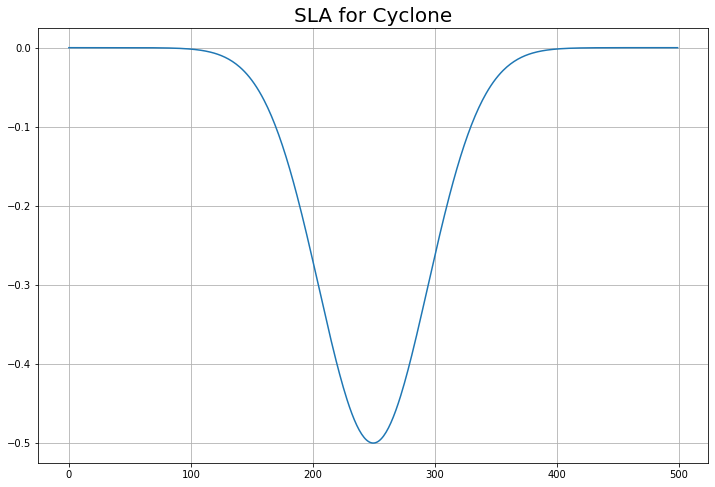

In [505]:
plt.figure(figsize=(12,8))
plt.title("SLA for Cyclone",fontsize=20)
plt.plot(sla0)
plt.grid()

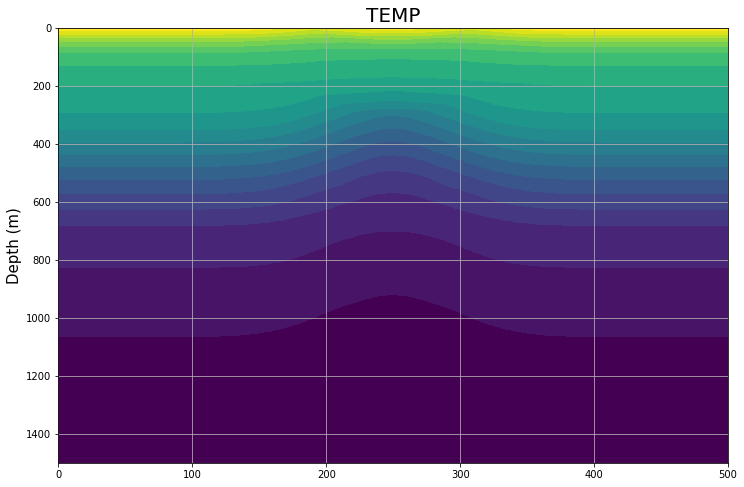

In [509]:
plt.figure(figsize=(12,8))
plt.pcolormesh(yta.reshape(n_z,n_test),cmap=cm.get_cmap('viridis',20))
plt.title("TEMP",fontsize=20)
plt.ylim(1500,0)
plt.ylabel("Depth (m)",fontsize=15)
plt.grid()
plt.show()

In [0]:
slta = yta.reshape(n_z,n_test)
difta = np.zeros((slta.shape[0],slta.shape[1]))
for nc in range(slta.shape[1]):
  difta[:,nc] = slta[:,nc] - slta[:,0]

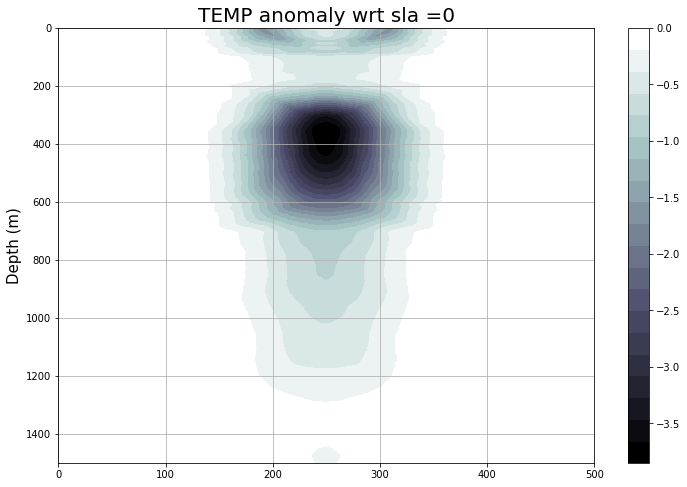

In [511]:
fig=plt.figure(figsize=(12,8))
ax = plt.pcolormesh(difta,cmap=cm.get_cmap('bone',20))
cb=fig.colorbar(ax)
plt.title("TEMP anomaly wrt sla =0",fontsize=20)
plt.ylim(1500,0)
plt.ylabel("Depth (m)",fontsize=15)
plt.grid()
plt.show()

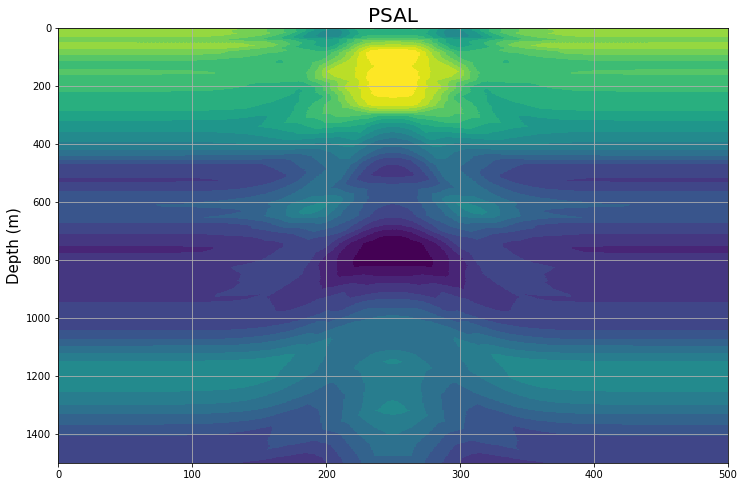

In [512]:
fig=plt.figure(figsize=(12,8))
plt.pcolormesh(ysa.reshape(n_z,n_test),cmap=cm.get_cmap('viridis',20))
plt.title("PSAL",fontsize=20)
plt.ylim(1500,0)
plt.ylabel("Depth (m)",fontsize=15)
plt.grid()
plt.show()

In [0]:
slsa = ysa.reshape(n_z,n_test)
difsa = np.zeros((slsa.shape[0],slsa.shape[1]))
for nc in range(slsa.shape[1]):
  difsa[:,nc] = slsa[:,nc] - slsa[:,0]

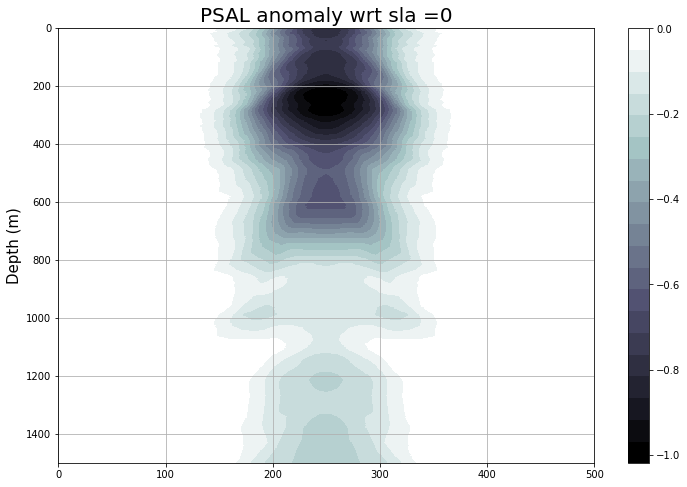

In [513]:
fig=plt.figure(figsize=(12,8))
ax = plt.pcolormesh(difsa,cmap=cm.get_cmap('bone',20))
cb=fig.colorbar(ax)
plt.title("PSAL anomaly wrt sla =0",fontsize=20)
plt.ylim(1500,0)
plt.ylabel("Depth (m)",fontsize=15)
plt.grid()
plt.show()

### Profiles validation

In [0]:
# Load model

typem = 'rnnSL'
model1 = load_model(path+'/data/model_'+typem+'_k1.h5')
model2 = load_model(path+'/data/model_'+typem+'_k2.h5')
model3 = load_model(path+'/data/model_'+typem+'_k3.h5')

# load the scalers

scaler_x = load(open(path+'/scalerx.pkl', 'rb'),allow_pickle=True)
scaler_yt = load(open(path+'/scalert.pkl', 'rb'),allow_pickle=True)
scaler_ys = load(open(path+'/scalers.pkl', 'rb'),allow_pickle=True)

In [0]:
dataps = data

Evaluation first model .....
Evaluation second model .....
Evaluation third model .....


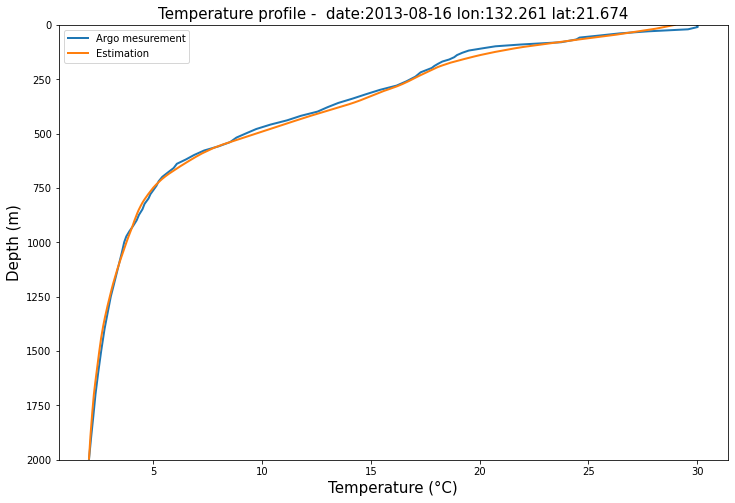

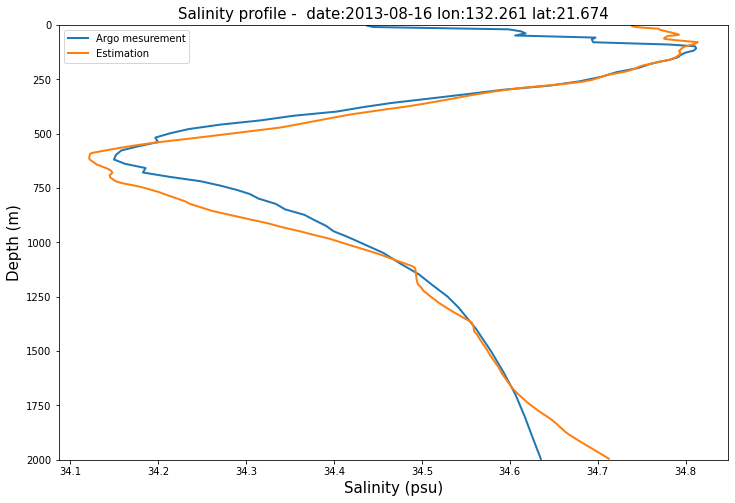

In [484]:
profiles = dataps['profile_ids'].values
profiles = np.unique(profiles)
n_profile = np.random.randint(0,len(profiles))
dateprofile = dataps['juld'].where((dataps['profile_ids'] == profiles[n_profile])).dropna().values
dateprofile = np.unique(dateprofile)
n_dateprofile = np.random.randint(0,len(dateprofile))

dt = dataps['temp'].where((dataps['profile_ids'] == profiles[n_profile]) & (dataps['juld'] == dateprofile[n_dateprofile])).dropna()
ds = dataps['psal'].where((dataps['profile_ids'] == profiles[n_profile]) & (dataps['juld'] == dateprofile[n_dateprofile])).dropna()
dp = dataps['pres'].where((dataps['profile_ids'] == profiles[n_profile]) & (dataps['juld'] == dateprofile[n_dateprofile])).dropna()
lon = dataps['lon'].where((dataps['profile_ids'] == profiles[n_profile]) & (dataps['juld'] == dateprofile[n_dateprofile])).dropna().values[0]
lat = dataps['lat'].where((dataps['profile_ids'] == profiles[n_profile]) & (dataps['juld'] == dateprofile[n_dateprofile])).dropna().values[0]
sla = dataps['sla'].where((dataps['profile_ids'] == profiles[n_profile]) & (dataps['juld'] == dateprofile[n_dateprofile])).dropna().values[0]

## Variables (inputs)
t = dateprofile[n_dateprofile]
t

## Profile estimation
n = 5000
t = t*np.ones(n)
loni = lon*np.ones(n)
lati = lat*np.ones(n)
z = np.linspace(0,int(np.max(dp)),n)
X = np.zeros([n,8])
X[:,0] = np.cos(loni*(np.pi/180))
X[:,1] = np.sin(loni*(np.pi/180))
X[:,2] = lati
X[:,3] = t
w = 1/365.25
X[:,4] = np.cos(np.pi*2*w*t)
X[:,5] = np.sin(np.pi*2*w*t)
X[:,6] = z
X[:,7] = sla*np.ones(n)

## Estimation
Xscaled= scaler_x.transform(X)
Xscaled = Xscaled.reshape((Xscaled.shape[0], 1, Xscaled.shape[1]))
print("Evaluation first model .....")
[yt1,ys1]= model1.predict(Xscaled)
yt1 = scaler_yt.inverse_transform(yt1)
ys1 = scaler_ys.inverse_transform(ys1)
print("Evaluation second model .....")
[yt2,ys2]= model2.predict(Xscaled)
yt2 = scaler_yt.inverse_transform(yt2)
ys2 = scaler_ys.inverse_transform(ys2)
print("Evaluation third model .....")
[yt3,ys3]= model3.predict(Xscaled)
yt3 = scaler_yt.inverse_transform(yt3)
ys3 = scaler_ys.inverse_transform(ys3)

# Mean

yt = (yt1+yt2+yt3)/3
ys = (ys1+ys2+ys3)/3

## Temperature plot

plt.figure(figsize=(12,8))
plt.plot(dt,dp,linewidth = 2, label = "Argo mesurement")
plt.plot(yt,z,linewidth = 2, label = "Estimation")
plt.title("Temperature profile -  date:"+str(datetime.fromtimestamp((dateprofile[n_dateprofile]-20*365.25)*24*3600))[:10]+' lon:'+str(lon)+' lat:'+str(lat),fontsize=15)
plt.ylim(2000,0)
plt.xlabel("Temperature (°C)",fontsize=15)
plt.ylabel("Depth (m)",fontsize=15)
plt.legend(fontsize = 10)
plt.show()

## Salinity plot

plt.figure(figsize=(12,8))
plt.plot(ds,dp,linewidth = 2, label = "Argo mesurement")
plt.plot(ys,z,linewidth = 2, label = "Estimation")
plt.title("Salinity profile -  date:"+str(datetime.fromtimestamp((dateprofile[n_dateprofile]-20*365.25)*24*3600))[:10]+' lon:'+str(lon)+' lat:'+str(lat),fontsize=15)
plt.ylim(2000,0)
plt.xlabel("Salinity (psu)",fontsize=15)
plt.ylabel("Depth (m)",fontsize=15)
plt.legend(fontsize = 10)
plt.show()

### Moonring validation